In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(1337)

# Load and process the data
aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv', index_col='datetime', parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-1.csv', index_col='datetime', parse_dates=True)
plug1_1 = plug1_1[:900000]

aggregate_df1 = aggregate_df1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)
plug1_1 = plug1_1.drop(['Unnamed: 0','id','device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'], axis=1)

/home/awinlab/anaconda3/envs/daniel_flower/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, length=100):
        self.X = X
        self.y = y
        self.length = length

    def __len__(self):
        return len(self.X) - self.length

    def __getitem__(self, idx):
        X = self.X[idx: idx + self.length]
        y = self.y[idx: idx + self.length]
        return X, y

mask = [i % 5 != 0 for i in range(len(aggregate_df1))]
X_train = aggregate_df1[~np.array(mask)]
X_test = aggregate_df1[mask]



mask1 = [i % 5 != 0 for i in range(len(plug1_1))]
y_train = plug1_1[~np.array(mask1)]
y_test = plug1_1[mask1]

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()


In [4]:
batch_size=60

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True, 
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers = 0, drop_last = True,
                                           collate_fn=lambda x: (torch.nn.utils.rnn.pad_sequence([i[0] for i in x], batch_first=True),
                                                                 torch.nn.utils.rnn.pad_sequence([i[1] for i in x], batch_first=True)))

In [5]:
import torch.nn.functional as F

class Power_Generator(nn.Module):
    # Refer to "KASELIMI M, VOULODIMOS A, PROTOPAPADAKIS E, et al. EnerGAN: A GENERATIVE ADVERSARIAL NETWORK FOR ENERGY DISAGGREGATION[C].2020 ICASSP"
    def __init__(self):
        super(Power_Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 256, kernel_size = 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 128, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 64, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(64, 128, kernel_size = 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(128, 256, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(256, 1, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, power_seq):
        return self.model(power_seq)
    
class Power_Discriminator(nn.Module):
    # Refer to "KASELIMI M, VOULODIMOS A, PROTOPAPADAKIS E, et al. EnerGAN: A GENERATIVE ADVERSARIAL NETWORK FOR ENERGY DISAGGREGATION[C].2020 ICASSP"
    def __init__(self, sequence_length):
        super(Power_Discriminator, self).__init__()
        self.sequence_length = sequence_length
        self.model = nn.Sequential(
            nn.Conv1d(2, 512, kernel_size = 32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(512, 256, kernel_size = 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(13824, 60),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(60, 1),
            nn.Sigmoid()
        )

    def forward(self, mains_seq, app_seq):

        mains_app = torch.cat((mains_seq, app_seq), dim = 1)
        validity = self.model(mains_app)
        return validity
    
def initialize(layer):
    # Xavier_uniform will be applied to conv1d, convtranspose1d and dense layer, to be consistent with Keras and Tensorflow
    if isinstance(layer,nn.Conv1d) or isinstance(layer, nn.Linear) or isinstance(layer, nn.ConvTranspose1d):    
        torch.nn.init.xavier_uniform_(layer.weight.data)
        if layer.bias is not None:
            torch.nn.init.constant_(layer.bias.data, val = 0.0)
       
    
gen_model = Power_Generator()
dis_model = Power_Discriminator(100)
gen_model = gen_model.cuda()
dis_model = dis_model.cuda()
gen_model.apply(initialize)
dis_model.apply(initialize)
    
    
optimizer_G = torch.optim.Adam(gen_model.parameters(), lr = 1e-3)
optimizer_D = torch.optim.Adam(dis_model.parameters(), lr = 1e-3)

adversarial_loss = torch.nn.BCELoss()
reconstruction_loss = torch.nn.L1Loss()
eval_loss = torch.nn.MSELoss()

gen_model = gen_model.to(device)
dis_model = dis_model.to(device)
adversarial_loss = adversarial_loss.to(device)
reconstruction_loss = reconstruction_loss.to(device)
eval_loss = eval_loss.to(device)

In [6]:
from torch.nn import L1Loss
import matplotlib.pyplot as plt
import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(tqdm.tqdm(train_loader)):
        X_batch = torch.transpose(X_batch, 2, 1)
        y_batch = torch.transpose(y_batch, 2, 1)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        valid = torch.ones(batch_size, 1).float().to(device)
        fake = torch.zeros(batch_size, 1).float().to(device)
                
        # Generator Training
        gen_model.train()

        batch_pred = gen_model(X_batch)
        fake_labels = dis_model(batch_pred, X_batch)
        
        ad_loss = adversarial_loss(fake_labels, valid)
        pix_loss = reconstruction_loss(batch_pred, y_batch)
        gen_loss = ad_loss + 100 * pix_loss
        
        optimizer_G.zero_grad()    
        gen_loss.backward()
        optimizer_G.step()

        # Discriminator Training
        dis_model.train()
        true_labels = dis_model(y_batch, X_batch)
        
        fake_labels = dis_model(batch_pred.detach(), X_batch)

        real_loss = adversarial_loss(true_labels, valid)
        fake_loss = adversarial_loss(fake_labels, fake)
        dis_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()    
        dis_loss.backward()
        optimizer_D.step()

    gen_model.eval()

    tqdm.tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Gen Loss: {gen_loss.item()}, Dis Loss: {dis_loss.item()}")


100%|███████████████████████████████████████| 2998/2998 [01:33<00:00, 32.08it/s]


Epoch [1/5], Step [2997/2998], Gen Loss: 141.84744262695312, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 2998/2998 [01:37<00:00, 30.83it/s]


Epoch [2/5], Step [2997/2998], Gen Loss: 821.8656005859375, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 2998/2998 [01:38<00:00, 30.55it/s]


Epoch [3/5], Step [2997/2998], Gen Loss: 200.660888671875, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 2998/2998 [01:38<00:00, 30.40it/s]


Epoch [4/5], Step [2997/2998], Gen Loss: 137.97488403320312, Dis Loss: 50.000003814697266


100%|███████████████████████████████████████| 2998/2998 [01:38<00:00, 30.28it/s]

Epoch [5/5], Step [2997/2998], Gen Loss: 1097.929931640625, Dis Loss: 50.000003814697266


In [7]:
predict = []
model = gen_model.cpu()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = torch.transpose(inputs, 2, 1)
        labels = torch.transpose(labels, 2, 1)
        outputs = model(inputs)
        predict.append(outputs[:,:,0])
predict = torch.cat(predict, dim=0)
predict_list = predict.numpy()

In [8]:
predict_list.shape

(719880, 1)

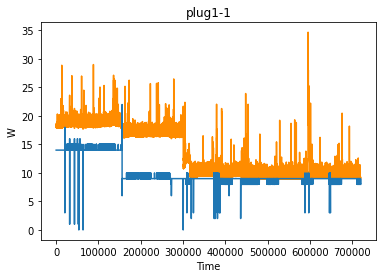

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='white')
plt.plot(predict_list,color='darkorange')
plt.plot(y_test)

plt.xlabel('Time')
plt.ylabel("W")
plt.title("plug1-1")
plt.savefig('/home/awinlab/Documents/kevin/Energan/pytorch/Energan_plug1-1.png')
plt.show()
